# Image Segmentation for Ceramic Grains

In [ ]:
# python 3.11
!pip install -r requirements.txt

In [1]:
# import general libraries
from pathlib import Path
import copy
import time
import random
from pprint import pprint

# import torch and tensor processing libraries
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# import lightning for quick model setup
import pytorch_lightning as pl

# import torchsummary for model information
from torchsummary import summary

# import ML image processing libraries
from PIL import Image
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as TF

# import plotting library
import matplotlib.pyplot as plt

# import segmentation library
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import losses
from segmentation_models_pytorch import metrics

/Users/balaramdb/Desktop/QS MLE Assignment/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## References

As we are building a minimum viable product with limited data, starting with transfer learning is always the best idea. We consider the reliable UNet architecture as a proof of concept (before we understand the limitations) using the ResNext50 encoder model.

The `segmentation_models_pytorch` library hosts a large array of segmentation architectures and pre-trained encoders for quick transfer learning and MVP creation. We employ this library's built-in models and its API for loss and metrics computation.

We discuss our design choices when we initialize the deep-learning model.

We utilize coding practices and frameworks from the code in the references (especially, in our model training).

References:
- Segmentation Models Pytorch ([github](https://github.com/qubvel/segmentation_models.pytorch/tree/master?tab=readme-ov-file))
- U-Net: Convolutional Networks for Biomedical Image Segmentation ([paper](https://arxiv.org/pdf/1505.04597.pdf)) ([github](https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/unet/__init__.py))
- Edge Detection Using U-Net Architecture ([github](https://github.com/iocak28/UNet_edge_detection/tree/master))
- Boundary learning by using weighted propagation in convolution network ([paper](https://www.sciencedirect.com/science/article/abs/pii/S1877750322001077)) ([github](https://github.com/clovermini/WPU-Net/tree/master?tab=readme-ov-file))
- Aggregated Residual Transformations for Deep Neural Networks ([paper](https://arxiv.org/pdf/1611.05431.pdf))
- PyTorch Docs
- PyTorch Lightning Docs
- TorchVision Docs

## Data Processing

We will first import our dataset images (4 training samples and 1 validation sample). We will perform basic data preparation transformations. As we only have a limited source of data, we increase our dataset size with random data augmentation relevant to the context of the data. Then we format the dataset for PyTorch training.

We make the following assumptions of our data and purpose:
- All ceramic images are in grayscale
- We assume for this purpose, they have resolution of 1600 x 1200 (h x w)
- We also assume that the only separating features between two adjacent grains are their visual features (not positional)
    - This assumption is seeded in the following statement: "individual grains can show contrast depending on their crystallographic orientation"
    - This assumption may not be true in a real setting are there are examples where two grains that look alike have a boundary running through them, but this case is more difficult to learn and is beyond the scope of a MVP
    - This assumption allows us to use a Fully Convolutional Network (FCN) such as U-Net

### Image Preparation 

As we are creating a minimum-viable product, we will down-sample the training images to ensure efficient training while we explore model training methods. The original image is rectangular, so we shrink it to a square as is standard practice to avoid bias and imbalanced data augmentations. For the segmentations, traditional bilinear interpolation would slowly erase the boundaries as they are thin, so we use max-pooling to preserve the grain boundaries in our segmentation mask. We also convert the image to grayscale as we assume all inputs are in grayscale only.

In [2]:
orig_res = (1600, 1200) # original resolution of the images
data_res = (256, 256)   # down-sampled training samples for images

# converts image to a tensor
to_image_tensor = T.ToImage()

# resizes it to a square using bilinear interpolation to maintain the smooth grain boundary colors
resize_to_square = T.Resize(size=data_res, antialias=False)

# convert to grayscale
to_grayscale = T.Grayscale(num_output_channels=1)

# convert 0-255 scale to 0-1
normalize_scale = T.ToDtype(torch.float32, scale=True)

# compose all transforms for image preparation
prepare_img_transform = T.Compose([
    to_image_tensor,
    resize_to_square,
    to_grayscale,
    normalize_scale
])

# we use max-pool to downsample the segmentation image to preserve the boundary values
# since they are thin, they vanish with traditional bilinear interpolation downsampling
max_pool = nn.MaxPool2d(2)

# resize upward after max-pooling using nearest interpolation to preserve boundary values
resize_up_to_square = T.Resize(
                            size=data_res,
                            interpolation=T.InterpolationMode.NEAREST_EXACT, 
                            antialias=False
                        )

# compose all transforms for segmentation preparation
prepare_seg_transform = T.Compose([
    to_image_tensor,
    to_grayscale,
    normalize_scale,
    max_pool,
    max_pool,
    max_pool,
    max_pool,
    resize_up_to_square,
    torch.ceil
])

# expand scale from 0-1 to 0-255
expand_scale = T.ToDtype(torch.uint8, scale=True)

# resize back to the original image
resize_to_original = T.Resize(size=orig_res, antialias=False)

# back to PIL formatted image in grayscale
to_pil_image = T.ToPILImage(mode='L')

# compose output transforms
output_transform = T.Compose([
  expand_scale,
  resize_to_original,
  to_pil_image
])

### Visualizing The Transformations

We create a sample training dataset to visualize our data processing and how the down-sampled images look.

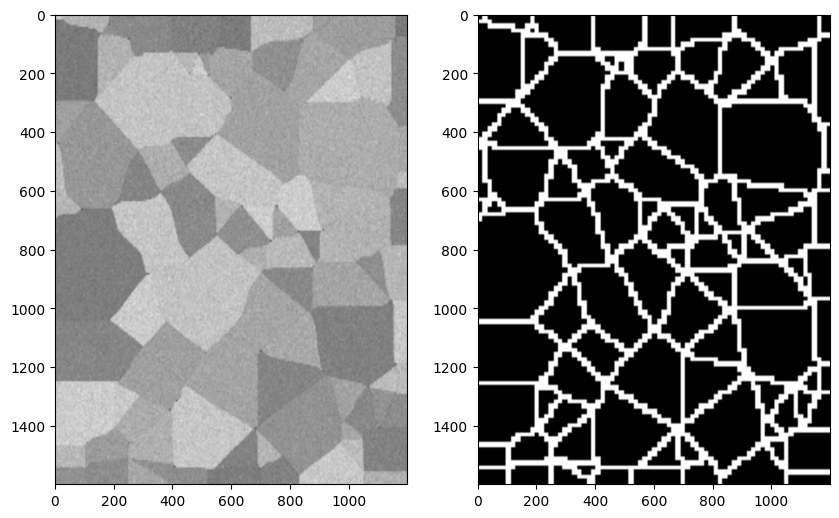

In [3]:
# create sample training dataset to visualize the data and the transforms

# download and prepare training data
train_path = './grain_segmentation_data/train/'
train_x, train_y = [], []
for i in range(4):
    img = prepare_img_transform(Image.open(f'{train_path}/Images/{i}.png'))
    seg = prepare_seg_transform(Image.open(f'{train_path}/Segmentations/{i}.png'))
    train_x.append(img)
    train_y.append(seg)

# display the 2nd image and its segmentation mask
i = 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(output_transform(train_x[i]), cmap='gray', vmin=0, vmax=255)
ax2.imshow(output_transform(train_y[i]), cmap='gray', vmin=0, vmax=255)

### Data Augmentation Random Transforms

Since we only have a limited sample of training and validation data, we can make the most of it by applying randomly generated data augmentations. We want our model to be invariant to the following things:
- Color invariant
    - Brightness invariant
    - Hue and saturation invariant
    - Contrast invariant
    - Blur (texture) invariant
    - Sharpness invariant
- Position invariant
    - Rotation invariant
    - Size invariant (up to 70% smaller)
    - Horizontal/vertical flip invariant
    
We can achieve model invariance to the above criteria if we produce data that is augmented according to the above criteria. These are random data transformations that will be processed by the PyTorch DataLoader. We refrain from a high frequency of positional transformations to allow the model to learn the baselines.

Note: Although the rotate introduces padding to the data, this can be ignored since a convolutional filter will not be influenced by 0 values in the image.

In [4]:
# color augmentation transforms
col_aug_transform = T.Compose([
    T.ColorJitter(brightness=0.4, hue=0.3, saturation=0.2, contrast=0.3), # randomly adjusts the color
    T.GaussianBlur(kernel_size=(9, 9), sigma=(0.1, 3)), # randomly blurs the image
    T.RandomAdjustSharpness(sharpness_factor=2), # randomly adjusts sharpness
    T.RandomAutocontrast(), # randomly adds constrast
    T.Grayscale() # turns it back to grayscale
])

# positional augmentation transforms
def pos_aug_transform(img, seg):
    # random rotate
    if random.random() > 0.5:
        rand_angle = random.random() * 360
        img = TF.rotate(img, angle=rand_angle)
        seg = TF.rotate(seg, angle=rand_angle)

    # random crop
    if random.random() > 0.5:
        i, j, h, w = T.RandomCrop.get_params(
                            img,
                            output_size=(
                                random.randint(int(data_res[0] * 0.7), data_res[0]),
                                random.randint(int(data_res[1] * 0.7), data_res[1])
                        )
                    )
        img = TF.crop(img, i, j, h, w)
        seg = TF.crop(seg, i, j, h, w)

    # random horizontal flip
    if random.random() > 0.5:
        img = TF.hflip(img)
        seg = TF.hflip(seg)

    # random vertical flip
    if random.random() > 0.5:
        img = TF.vflip(img)
        seg = TF.vflip(seg)

    # resize back
    img = TF.resize(img, size=data_res)
    seg = TF.resize(seg, size=data_res)


    # adjust seg to be a mask with 0 and 1 values
    # we take the ceiling to increase the boundary size as it makes the learning process easier
    seg = torch.ceil(seg)

    return img, seg

### Dataset Population & Formatting

We create a dataset that includes both our original data and their augmented versions. To increase the learning speed, we increase our dataset with augmentated data (given a multiplicity). This allows the model to see a variety of samples in each epoch.

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, dir, mult=1, img_transform=None, seg_transform=None, col_aug_transform=None, pos_aug_transform=None):
        self.img_paths = list((Path(dir) / 'Images').glob("*.png"))
        self.seg_paths = list((Path(dir) / 'Segmentations').glob("*.png"))

        assert len(self.img_paths) == len(self.seg_paths)

        self.mult = mult

        self.img_transform = img_transform
        self.seg_transform = seg_transform
        self.col_aug_transform = col_aug_transform
        self.pos_aug_transform = pos_aug_transform

    def __len__(self):
        return len(self.img_paths) * self.mult

    def __getitem__(self, idx):
        i = idx % len(self.img_paths)

        # open images
        img = Image.open(self.img_paths[i])
        seg = Image.open(self.seg_paths[i])

        # perform preparation transforms
        if self.img_transform:
            img = self.img_transform(img)
        if self.seg_transform:
            seg = self.seg_transform(seg)
                 
        # perform color transforms *only* on new augmented samples (restore original data samples)
        if self.col_aug_transform and idx >= len(self.img_paths):
            img = self.col_aug_transform(img)

        # perform positional transforms *only* on new augmented samples (restore original data samples)
        if self.pos_aug_transform and idx >= len(self.img_paths):
            img, seg = self.pos_aug_transform(img, seg)

        return img, seg

In [6]:
# create train dataset with a multiplicity of 30 (total of 4 * 30 = 120 training samples)
train_data = CustomImageDataset(
                dir='./grain_segmentation_data/train/',
                mult=30, 
                img_transform=prepare_img_transform,
                seg_transform=prepare_seg_transform,
                col_aug_transform=col_aug_transform,
                pos_aug_transform=pos_aug_transform
            )

# create validation dataset with a multiplicity of 30 (total of 1 * 30 = 30 validation samples)
val_data = CustomImageDataset(
                dir='./grain_segmentation_data/validation/',
                mult=30,
                img_transform=prepare_img_transform,
                seg_transform=prepare_seg_transform,
                col_aug_transform=col_aug_transform,
                pos_aug_transform=pos_aug_transform
            )

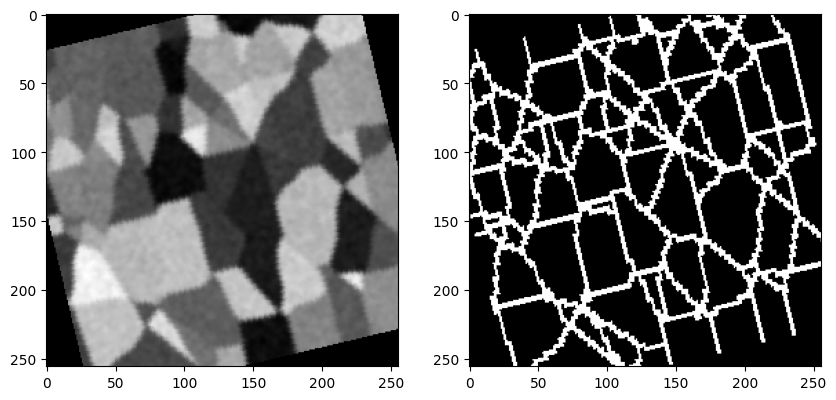

In [7]:
# i = 4 is an augmented sample of training data sample i = 0
# visualize the random transforms conducted (re-run to produce different results)
i = 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
img, seg = train_data[i]
ax1.imshow(img[0], cmap='gray', vmin=0, vmax=1)
ax2.imshow(seg[0], cmap='gray', vmin=0, vmax=1)

In [8]:
# configure data loaders for training and validation
train_dataloader = DataLoader(dataset=train_data, batch_size=4, num_workers=0, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=8, num_workers=0, shuffle=False)

## Model

The purpose of this model is to take a ceramic grain image and produce a segmentation mask that separates each of the grain. The mask will help the team measure the grain's size distributions for each batch of materials.

Since we are creating a MVP, a standard architecture for image and instance segmentation models is U-Net. This architecture originally was used for medical image segmentation which is a similar use case as grain segmentation (both are partitioning the image with a segmentation mask). Hence, we start with this architecture.

Due to our limited data, we first start with transfer learning as it will be hard for a model to freshly learn all the required image features with just a few samples of data. We will use a pre-trained model and directly fine-tune its layers with our data. We experiment with two types of transfer learning:

1. Decoder-only fine-tuning: this allows us to train the model to learn how to use the pre-trained feature extractor to create an accurate segmentation mask.
2. Total fine-tuning: this allows us to train the entire model (encoder and decoder) so that it can learn to capture valuable features and then use them to create an accurate segmentation mask.

There are many popular choices for a pre-trained encoder such as ResNet, VGG, DenseNet, Inception, ResNeXt, SE-Net, etc. Each of these have their own advantages and disadvantages. Since we are only building a MVP and not trying to find the "best" model, we wish to stick to the general purpose ResNet architecture. VGG is another popular choice, but since ResNet is much deeper, we believe it will be a better choice when we want to extract smaller and finer boundary features. ResNet also passes the residuals of the encoder layers to the decoders which is important in edge detection as sometimes features can be lost in the downsampling process. ResNeXt advances on the ResNet architecture with better results, so we choose this model first.

In particular, we ResNeXt50 which was trained on a weakly-supervised ImageNet dataset. This is known to have more general feature encoders which we prefer since ResNeXt was originally for image classification.

Note: In our experimentation, we found similar training results with ResNet, VGG, and ResNeXt so a deeper analysis can be conducted for a final product.

We consider 3 loss functions.

- Binary Cross Entropy: This is a traditional loss function in binary classification, but it can suffer with imbalanced data (in our case, there are much more pixels that are non-boundary vs boundary).
- IoU Loss: This is a common metric for image segmentation and is specified as our success metric. It is computed by taking the intersection over the union of the predicted and target segmentation mask.
- Dice Loss: This is a common loss function used for image segmentation as is similar to IoU loss but it weights false positives and negatives less than IoU, so this is more suited to object detection than image segmentation.

We experimented with multiple combinations of these loss functions, but to produce the most robust and general model, our loss function is the average of these 3 loss functions as they evaluate different aspects of our predictions which are all important.

Our evaluation metric is the IoU score which is given by computing the intersection divided by the union of the predicted and target segmentation mask. Generally a good score is 0.5 or greater in object detection, but in boundary detection, we might ask for a higher score. However, we can get a higher score by adjusting the "width" of the boundary in post-processing which we do not explore in this proof of concept experiment.

In [9]:
# we use PyTorch Lightning for streamlined training processes
class SegmentationModel(pl.LightningModule):
    def __init__(self, in_channels, out_channels, freeze=None):
        super().__init__()
        
        self.model = smp.Unet(
            encoder_name="resnext50_32x4d",  # we choose resnext50 to train on a local machine
            encoder_weights="swsl",          # weakly semi-supervised learning on imagenet dataset
            in_channels=in_channels,
            classes=out_channels
        )
        
        # freeze given layers (ex. encoder/decoder)
        if freeze:
            for n, p in self.model.named_parameters():
                if n.startswith(freeze):
                    p.requires_grad = False
                else:
                    p.requires_grad = True
        
        # we save the pre-processing weights and convert to grayscale
        params = smp.encoders.get_preprocessing_params('resnext50_32x4d')
        self.register_buffer("std", torch.tensor(params["std"]).mean().view(1, 1, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).mean().view(1, 1, 1, 1))
        
        # various loss functions (built-in with smp API)
        self.bce_loss_fn = losses.SoftBCEWithLogitsLoss()
        self.dice_loss_fn = losses.DiceLoss(mode=losses.BINARY_MODE, from_logits=True)
        self.iou_loss_fn = losses.JaccardLoss(mode=losses.BINARY_MODE, from_logits=True)
        
        self.training_step_outputs = []
        self.validation_step_outputs = []
        
    def forward(self, img):
        img = (img - self.mean) / self.std
        pred_seg = self.model(img)
        return pred_seg
    
    def loss_fn(self, img, seg):
        bce_loss = self.bce_loss_fn(img, seg)
        dice_loss = self.dice_loss_fn(img, seg)
        iou_loss = self.iou_loss_fn(img, seg)

        # take average of the losses
        loss = 1 / 3 * bce_loss + 1 / 3 * dice_loss + 1 / 3 * iou_loss

        return loss
    
    def shared_step(self, batch, stage):
        img = batch[0]
        seg = batch[1]
        
        # get prediction in logits form
        logits_seg = self.forward(img)
        
        # compute loss
        loss = self.loss_fn(logits_seg, seg)
        
        # process the prediction segmentation using sigmoid
        pred_seg = logits_seg.sigmoid().round()
        
        # compute statistics
        tp, fp, fn, tn = metrics.get_stats(pred_seg.long(), seg.long(), mode="binary")
        outputs = {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }
        
        # save the statistics
        if stage == 'train':
            self.training_step_outputs.append(outputs)
        else:
            self.validation_step_outputs.append(outputs)
        
        return loss

    def shared_epoch_end(self, outputs, stage):
        # extract statistics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])
        
        # compute iou scores
        per_img_iou = metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        epoch_metrics = {
            f'{stage}_per_img_iou': per_img_iou,
            f'{stage}_dataset_iou': dataset_iou
        }
        self.log_dict(epoch_metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "val")

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "val")
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        # we use a traditional Adam optimizer
        learning_rate = 1e-4
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=learning_rate)
        
        # learning rate scheduler as we get closer to a minima
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=11, gamma=0.1)
        
        return [optimizer], [scheduler]

### Decoder-only Fine-tuning

In [10]:
model1 = SegmentationModel(in_channels=1, out_channels=1, freeze='encoder')
summary(model1, input_size=(1, data_res[0], data_res[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]           8,192
       BatchNorm2d-6          [-1, 128, 64, 64]             256
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]           4,608
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          32,768
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [11]:
# training seems to flatten at around 15-20 epochs
trainer = pl.Trainer(max_epochs=20, log_every_n_steps=1)

trainer.fit(
    model1,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/balaramdb/Desktop/QS MLE Assignment/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name         | Type                  | Params
-------------------------------------------------------
0 | model        | Unet                  | 32.0 M
1 | bce_loss_fn  | SoftBCEWithLogitsLoss | 0     
2 | dice_loss_fn | DiceLoss              | 0     
3 | iou_loss_fn  | JaccardLoss    

Sanity Checking: |                                                                                  | 0/? [00:00<?, ?it/s]

/Users/balaramdb/Desktop/QS MLE Assignment/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/balaramdb/Desktop/QS MLE Assignment/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 30/30 [00:53<00:00,  0.56it/s, v_num=18]
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  0.54it/s]
Epoch 1: 100%|█| 30/30 [01:02<00:00,  0.48it/s, v_num=18, val_per_img_iou=0.293, val_dataset_iou=0.294, train_per_img_iou=
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  0.37it/s]
Epoch 2: 100%|█| 30/30 [00:55<00:00,  0.54it/s, v_num=18, val_per_img_iou=0.439, val_dataset_iou=0.438, train_per_img_iou=
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataL

Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  0.55it/s]
Epoch 9: 100%|█| 30/30 [00:57<00:00,  0.52it/s, v_num=18, val_per_img_iou=0.571, val_dataset_iou=0.575, train_per_img_iou=
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  0.45it/s]
Epoch 10: 100%|█| 30/30 [00:57<00:00,  0.52it/s, v_num=18, val_per_img_iou=0.609, val_dataset_iou=0.612, train_per_img_iou
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  0.49it/s]
Epoch 11: 100%|█

Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  0.49it/s]
Epoch 17: 100%|█| 30/30 [01:00<00:00,  0.49it/s, v_num=18, val_per_img_iou=0.596, val_dataset_iou=0.599, train_per_img_iou
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  0.50it/s]
Epoch 18: 100%|█| 30/30 [01:07<00:00,  0.44it/s, v_num=18, val_per_img_iou=0.597, val_dataset_iou=0.601, train_per_img_iou
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  0.35it/s]
Epoch 19: 100%|█| 30/30 [01:03<00:00,  0.47it/s, v_num=18, val_per_img_iou=0.611, val_dataset_iou=0.614, train_per_img_iou
Validation: |   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█| 30/30 [01:12<00:00,  0.41it/s, v_num=18, val_per_img_iou=0.598, val_dataset_iou=0.601, train_per_img_iou


In [12]:
val_metrics = trainer.validate(model1, dataloaders=val_dataloader, verbose=False)
pprint(val_metrics)

Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  0.44it/s]
[{'val_dataset_iou': 0.6006258726119995, 'val_per_img_iou': 0.5976974964141846}]


#### Visualizing Results

For val sample 0: iou = 0.5890541672706604
For val sample 1: iou = 0.6527979373931885
For val sample 2: iou = 0.6472495794296265
For val sample 3: iou = 0.6389591097831726
For val sample 4: iou = 0.6635446548461914


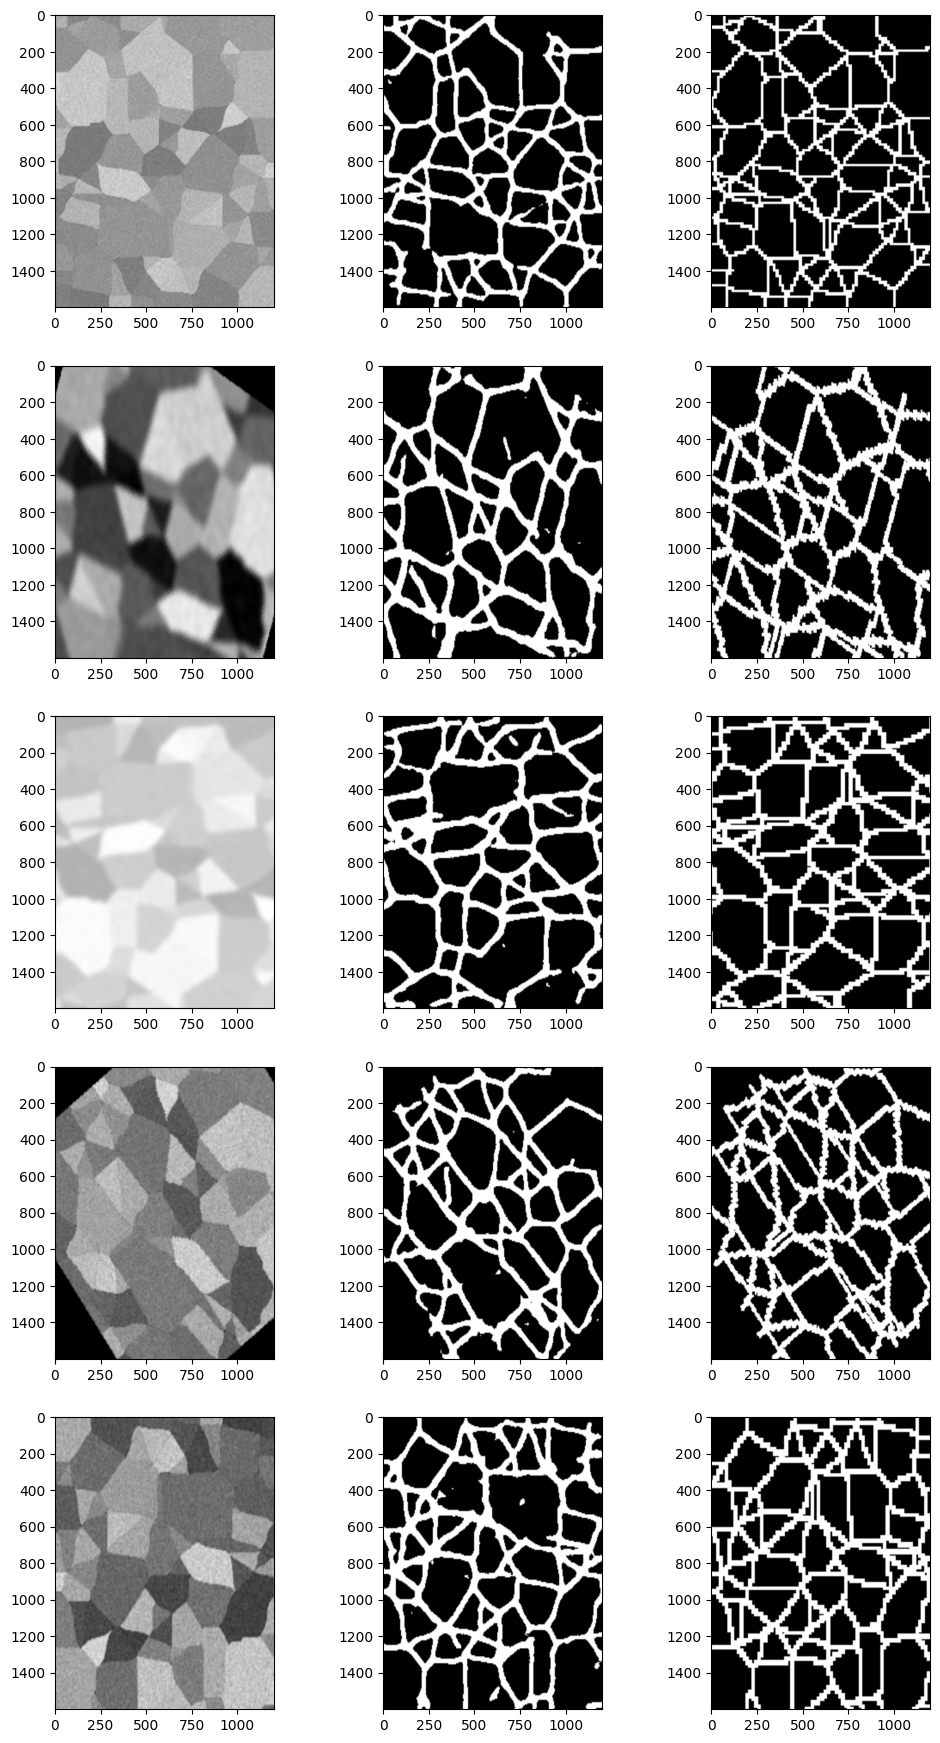

In [13]:
model1.eval()
with torch.no_grad():
    fig, axs = plt.subplots(5, 3, figsize=(12, 22))
    
    for i in range(5):
        sample = val_data[i]
        img = sample[0].view(1, 1, data_res[0], data_res[1])
        pred_seg = torch.sigmoid(model1(img)).round()
        seg = sample[1].view(1, 1, data_res[0], data_res[1])

        axs[i, 0].imshow(output_transform(img[0]), cmap='gray', vmin=0, vmax=255)
        axs[i, 1].imshow(output_transform(pred_seg[0]), cmap='gray', vmin=0, vmax=255)
        axs[i, 2].imshow(output_transform(seg[0]), cmap='gray', vmin=0, vmax=255)

        tp, fp, fn, tn = metrics.get_stats(pred_seg.long(), seg.long(), mode="binary")
        iou = metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        print(f'For val sample {i}: iou = {iou}')

For train sample 0: iou = 0.6016170978546143
For train sample 1: iou = 0.630476176738739
For train sample 2: iou = 0.6263322830200195
For train sample 3: iou = 0.5847010016441345
For train sample 4: iou = 0.6080688834190369
For train sample 5: iou = 0.6221281886100769
For train sample 6: iou = 0.6602510809898376
For train sample 7: iou = 0.5515040159225464


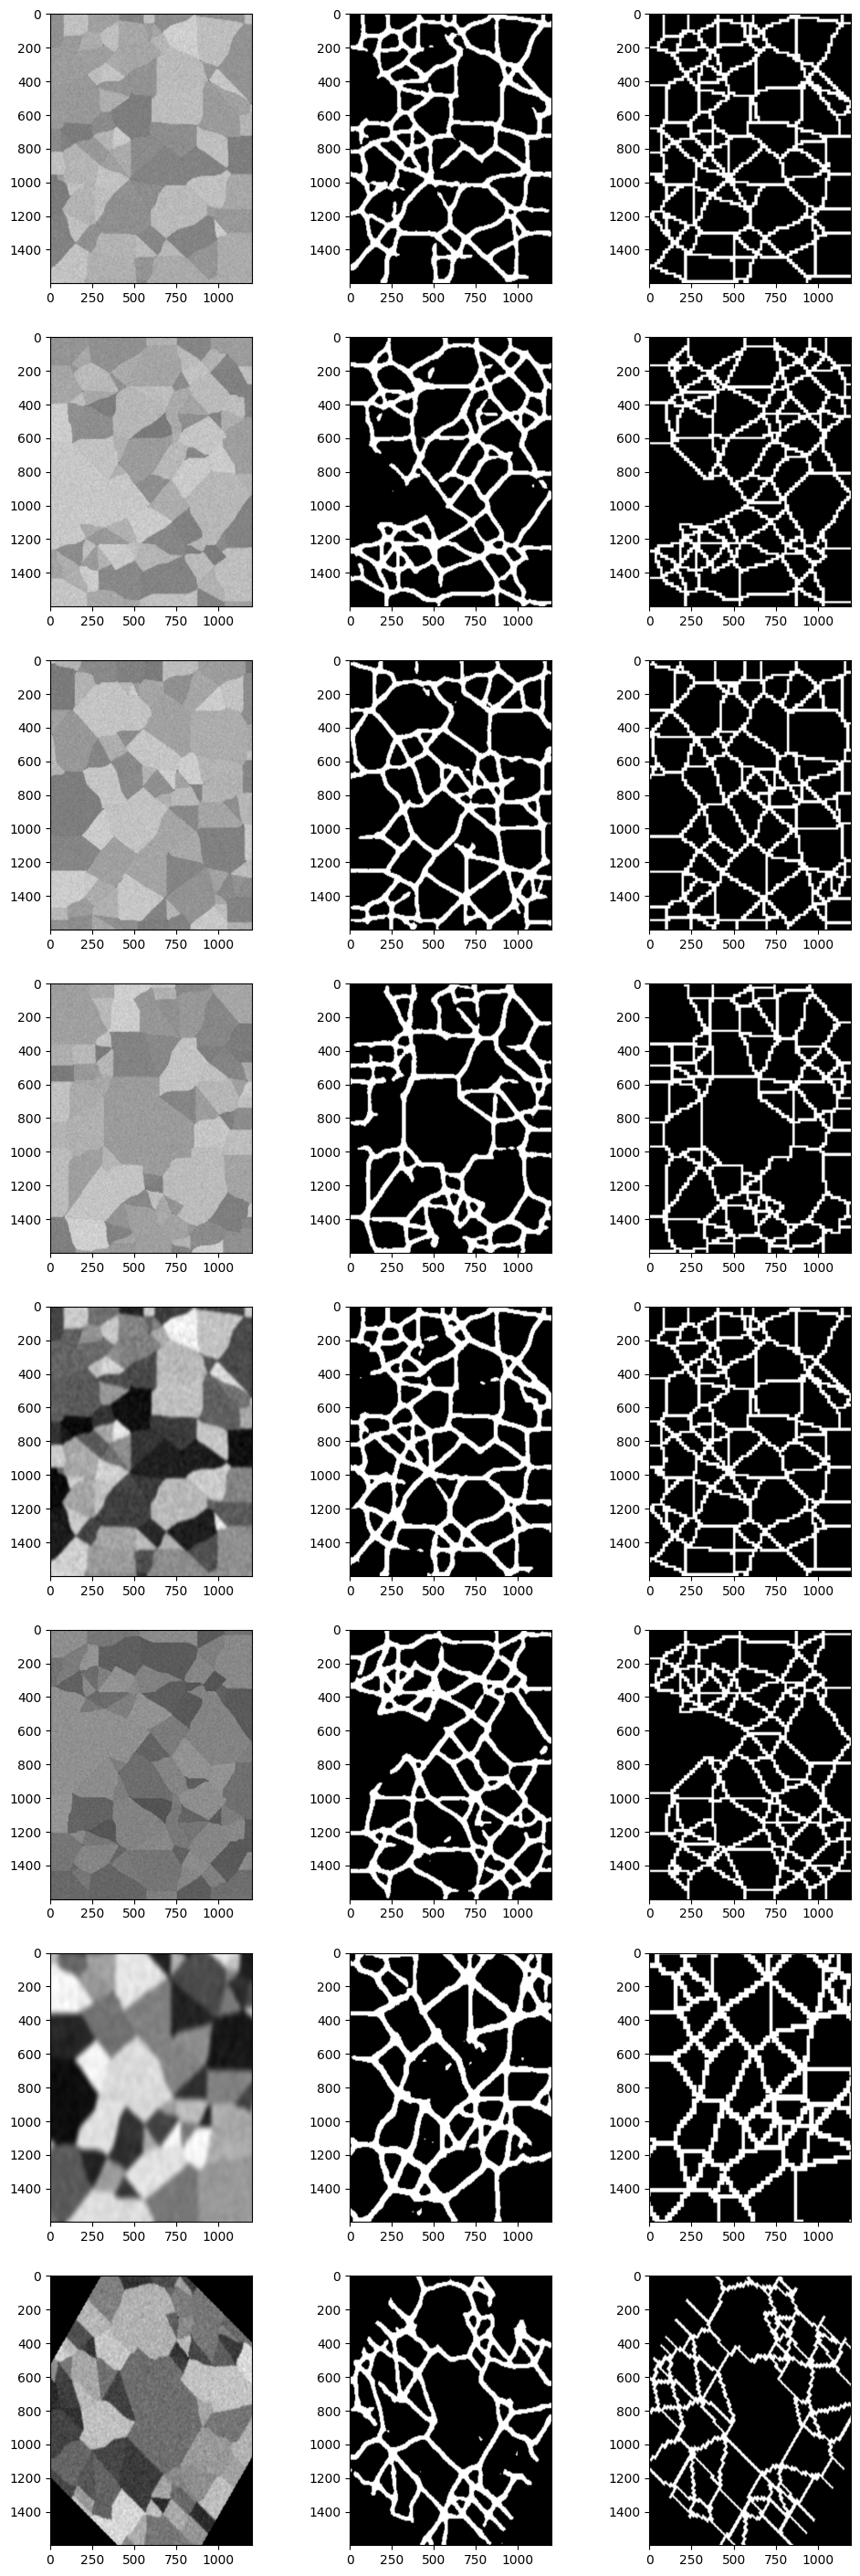

In [14]:
model1.eval()
with torch.no_grad():
    fig, axs = plt.subplots(8, 3, figsize=(12, 36))
    
    for i in range(8):
        sample = train_data[i]
        img = sample[0].view(1, 1, data_res[0], data_res[1])
        pred_seg = torch.sigmoid(model1(img)).round()
        seg = sample[1].view(1, 1, data_res[0], data_res[1])

        axs[i, 0].imshow(output_transform(img[0]), cmap='gray', vmin=0, vmax=255)
        axs[i, 1].imshow(output_transform(pred_seg[0]), cmap='gray', vmin=0, vmax=255)
        axs[i, 2].imshow(output_transform(seg[0]), cmap='gray', vmin=0, vmax=255)

        tp, fp, fn, tn = metrics.get_stats(pred_seg.long(), seg.long(), mode="binary")
        iou = metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        print(f'For train sample {i}: iou = {iou}')

### Total Fine-tuning

In [15]:
model2 = SegmentationModel(in_channels=1, out_channels=1)
summary(model2, input_size=(1, data_res[0], data_res[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]           8,192
       BatchNorm2d-6          [-1, 128, 64, 64]             256
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]           4,608
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          32,768
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [16]:
# training seems to flatten at around 15-20 epochs
trainer = pl.Trainer(max_epochs=20, log_every_n_steps=1)

trainer.fit(
    model2,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type                  | Params
-------------------------------------------------------
0 | model        | Unet                  | 32.0 M
1 | bce_loss_fn  | SoftBCEWithLogitsLoss | 0     
2 | dice_loss_fn | DiceLoss              | 0     
3 | iou_loss_fn  | JaccardLoss           | 0     
-------------------------------------------------------
32.0 M    Trainable params
0         Non-trainable params
32.0 M    Total params
127.947   Total estimated model params size (MB)


Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 30/30 [01:50<00:00,  0.27it/s, v_num=19]
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  0.46it/s]
Epoch 1: 100%|█| 30/30 [01:52<00:00,  0.27it/s, v_num=19, val_per_img_iou=0.328, val_dataset_iou=0.327, train_per_img_iou=
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  0.41it/s]
Epoch 2: 100%|█| 30/30 [01:49<00:00,  0.27it/s, v_num=19, val_per_img_iou=0.450, val_dataset_iou=0.450, train_per_img_iou=
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataL

Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  0.46it/s]
Epoch 9: 100%|█| 30/30 [01:49<00:00,  0.27it/s, v_num=19, val_per_img_iou=0.586, val_dataset_iou=0.591, train_per_img_iou=
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  0.41it/s]
Epoch 10: 100%|█| 30/30 [01:54<00:00,  0.26it/s, v_num=19, val_per_img_iou=0.613, val_dataset_iou=0.616, train_per_img_iou
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  0.53it/s]
Epoch 11: 100%|█

Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  0.42it/s]
Epoch 17: 100%|█| 30/30 [01:57<00:00,  0.26it/s, v_num=19, val_per_img_iou=0.614, val_dataset_iou=0.620, train_per_img_iou
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  0.36it/s]
Epoch 18: 100%|█| 30/30 [01:48<00:00,  0.28it/s, v_num=19, val_per_img_iou=0.627, val_dataset_iou=0.632, train_per_img_iou
Validation: |                                                                                       | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  0.46it/s]
Epoch 19: 100%|█| 30/30 [01:45<00:00,  0.29it/s, v_num=19, val_per_img_iou=0.622, val_dataset_iou=0.626, train_per_img_iou
Validation: |   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█| 30/30 [01:56<00:00,  0.26it/s, v_num=19, val_per_img_iou=0.620, val_dataset_iou=0.624, train_per_img_iou


In [17]:
val_metrics = trainer.validate(model2, dataloaders=val_dataloader, verbose=False)
pprint(val_metrics)

Validation DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  0.44it/s]
[{'val_dataset_iou': 0.6211312413215637, 'val_per_img_iou': 0.6177129149436951}]


#### Visualizing Results

For val sample 0: iou = 0.6031998991966248
For val sample 1: iou = 0.5372641682624817
For val sample 2: iou = 0.5453913807868958
For val sample 3: iou = 0.6565591096878052
For val sample 4: iou = 0.5515099763870239


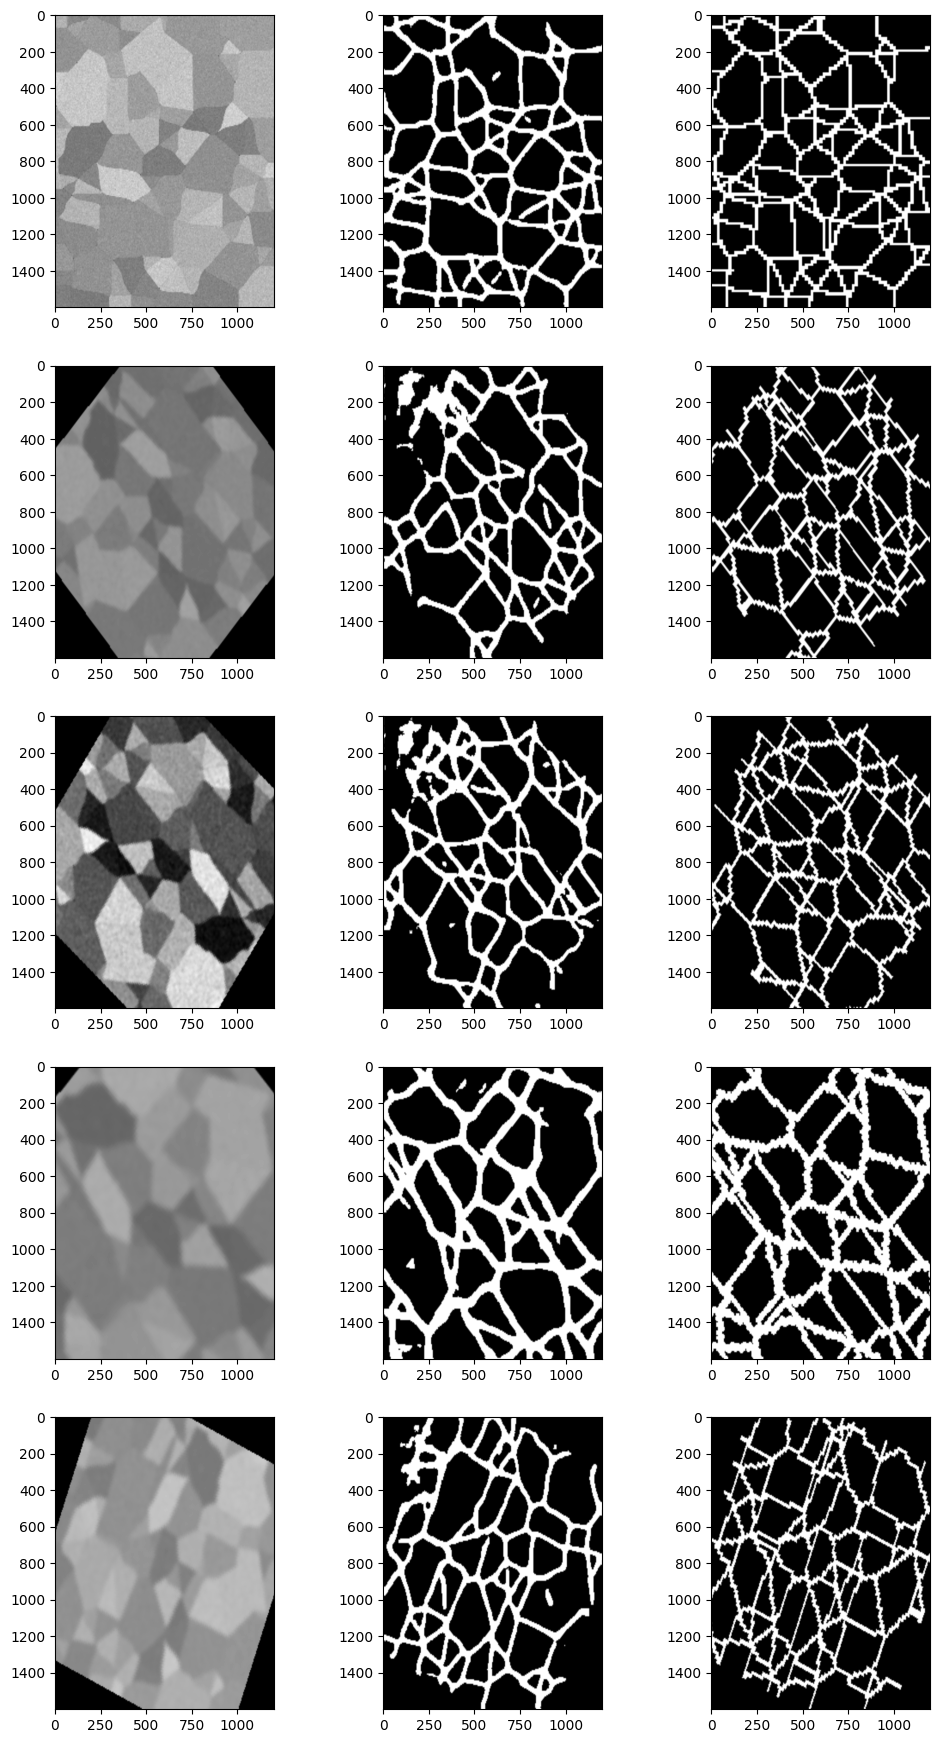

In [18]:
model2.eval()
with torch.no_grad():
    fig, axs = plt.subplots(5, 3, figsize=(12, 22))
    
    for i in range(5):
        sample = val_data[i]
        img = sample[0].view(1, 1, data_res[0], data_res[1])
        pred_seg = torch.sigmoid(model2(img)).round()
        seg = sample[1].view(1, 1, data_res[0], data_res[1])

        axs[i, 0].imshow(output_transform(img[0]), cmap='gray', vmin=0, vmax=255)
        axs[i, 1].imshow(output_transform(pred_seg[0]), cmap='gray', vmin=0, vmax=255)
        axs[i, 2].imshow(output_transform(seg[0]), cmap='gray', vmin=0, vmax=255)

        tp, fp, fn, tn = metrics.get_stats(pred_seg.long(), seg.long(), mode="binary")
        iou = metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        print(f'For val sample {i}: iou = {iou}')

For train sample 0: iou = 0.6388960480690002
For train sample 1: iou = 0.657220721244812
For train sample 2: iou = 0.644658625125885
For train sample 3: iou = 0.6278783082962036
For train sample 4: iou = 0.6836227774620056
For train sample 5: iou = 0.5490239858627319
For train sample 6: iou = 0.6719427108764648
For train sample 7: iou = 0.6619457006454468


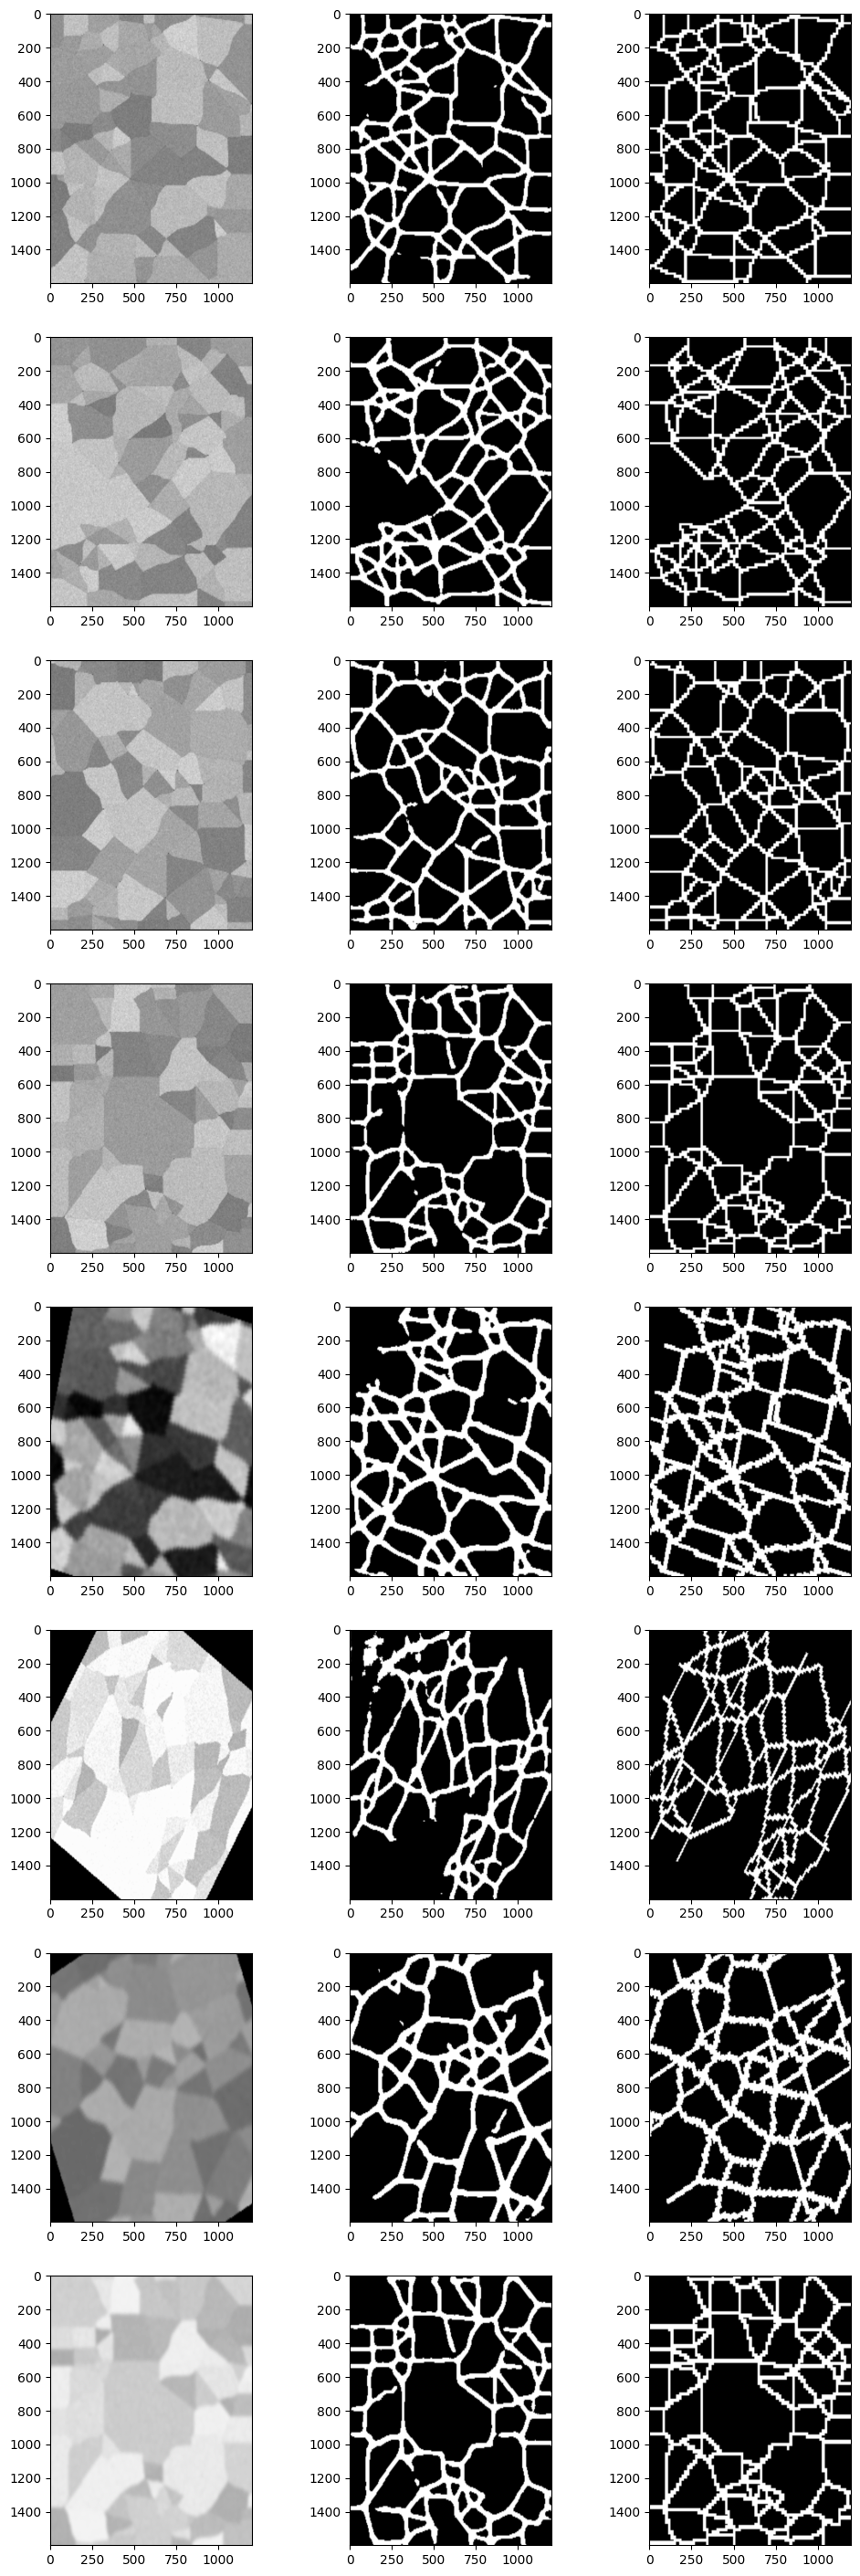

In [19]:
model2.eval()
with torch.no_grad():
    fig, axs = plt.subplots(8, 3, figsize=(12, 36))
    
    for i in range(8):
        sample = train_data[i]
        img = sample[0].view(1, 1, data_res[0], data_res[1])
        pred_seg = torch.sigmoid(model2(img)).round()
        seg = sample[1].view(1, 1, data_res[0], data_res[1])

        axs[i, 0].imshow(output_transform(img[0]), cmap='gray', vmin=0, vmax=255)
        axs[i, 1].imshow(output_transform(pred_seg[0]), cmap='gray', vmin=0, vmax=255)
        axs[i, 2].imshow(output_transform(seg[0]), cmap='gray', vmin=0, vmax=255)

        tp, fp, fn, tn = metrics.get_stats(pred_seg.long(), seg.long(), mode="binary")
        iou = metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        print(f'For train sample {i}: iou = {iou}')

## Discussion

We got the following IoU results for both fine-tuning models on the one validation sample

|     | Decoder-only Fine-tuning | Total Fine-tuning |
| --- | ------------------------ | ----------------- |
| IoU |         0.589            |       0.603        |

As the IoU is greater than 0.5, we can consider our model's performance to be good, especially for a basic proof of concept. Both models are close in their IoU scores which means that just decoding the feature extraction of a pre-trained model is quite good at determining the grain boundaries. However, it struggles when adjacent grains have a similar color profile as this is not normal in general image classifications (different objects tend to have different colors).

Therefore, we explore a total fine-tuning setup where we also adjust the encoder. We can see below in the predictions of both models that with total fine-tuning we were able to predict some of the more "difficult" grain boundaries where the adjacent colors are similar. This is because the encoder learned to extract finer features that were relevant to our use case.

For model 1: iou = 0.5890541672706604
For model 2: iou = 0.6031998991966248


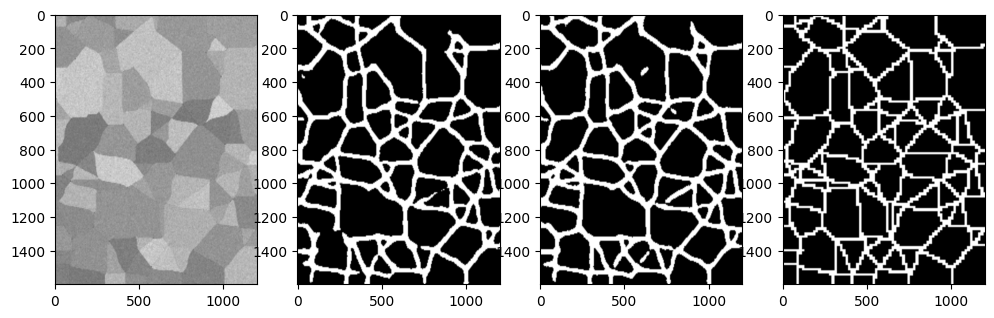

In [23]:
model1.eval()
model2.eval()
with torch.no_grad():
    fig, axs = plt.subplots(1, 4, figsize=(12, 10))

    sample = val_data[0]
    img = sample[0].view(1, 1, data_res[0], data_res[1])
    
    pred1_seg = torch.sigmoid(model1(img)).round()
    pred2_seg = torch.sigmoid(model2(img)).round()
    
    seg = sample[1].view(1, 1, data_res[0], data_res[1])

    axs[0].imshow(output_transform(img[0]), cmap='gray', vmin=0, vmax=255)
    axs[1].imshow(output_transform(pred1_seg[0]), cmap='gray', vmin=0, vmax=255)
    axs[2].imshow(output_transform(pred2_seg[0]), cmap='gray', vmin=0, vmax=255)
    axs[3].imshow(output_transform(seg[0]), cmap='gray', vmin=0, vmax=255)

    tp, fp, fn, tn = metrics.get_stats(pred1_seg.long(), seg.long(), mode="binary")
    iou = metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
    print(f'For model 1: iou = {iou}')
    
    tp, fp, fn, tn = metrics.get_stats(pred2_seg.long(), seg.long(), mode="binary")
    iou = metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
    print(f'For model 2: iou = {iou}')

From left to right: input image, decoder-only fine-tuning prediction, total fine-tuning prediction, ground truth segmentation mask.

It is clear from this experiment that deep learning can definitely be the answer to producing generalized grain boundary segmentations.

### Next Steps

We discuss some next steps and improvements we can make to our model to gain better results.
unet++ for more feature transfer from the encoder to the decoder.
- With more data samples we can increase the generalization power of the model. Furthermore, by training on a larger dataset of augmented samples, we can also increase the generalization power (this would require larger compute resources).
- We can perform cross validation or other regularization measures to increase the robustness of the model.
- To save on computing costs we downsample our data, but if we train on higher resolution data, we could produce more accurate results.
- In our crude observations, we notice that the predicted segmentation mask produces "wider" grain boundaries, so if we conduct some post-processing interpolation to "shrink" the boundaries while resizing and up-sampling, we could achieve a better IoU.